In [127]:
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt
from collections import deque

def fifo(cache, item, m):
    hit = item in cache
    if not hit:
        cache.popleft()
        cache.append(item)
    return hit

def rand(cache, item, m):
    hit = item in cache
    if not hit:
        ind = random.randint(0, m - 1)
        cache[ind] = item
    return hit
        
def poisson(l):
    return -np.log(random.random()) / l
        
def run_simulation(m, n, policy, duration, batches, warmup):
    
    # some of these are initialised for performance boost
    # f.e. cache_range so that we don't need to recalculate
    # for every batch
    cache_range = range(m)
    cache = deque([i for i in cache_range])
    ls = [1 / i for i in range(1, n + 1)]
    arrivals = [0 for l in ls]
    end = duration + warmup
    out = []
    n_range = range(n)
    
    for i in range(batches):
        
        res = []
        # instead of creating a new arrays we can just reuse the ones
        # we calculated before. We can also reuse the 
        for j in n_range:
            arrivals[j] = poisson(ls[j])
        for j in cache_range:
            cache[j] = j
            
        hits = 0
        queries = 0
        curr = 0
        counter = 0
        while(curr < end):
            ind = np.argmin(arrivals)
            curr = arrivals[ind]
            hit = policy(cache, ind, m)
            arrivals[ind] = poisson(ls[ind]) + curr
            if hit:
                hits += 1
            queries += 1
            if (curr >= warmup):
                res.append(hits / queries)
        out.append(res)
    return out

def get_ci(x, alpha=0.025):
    batches = len(x)
    x_bar = np.mean(x) # average
    s = np.std(x, ddof=1) / np.sqrt(batches) # sample variance
    if batches > 40:
        t = stats.normal.cdf()
    else:
        t = stats.t.ppf(1 - alpha / 2,df=batches - 1)
    d = t * s / np.sqrt(batches)
    return [x_bar - d, x_bar, x_bar + d]


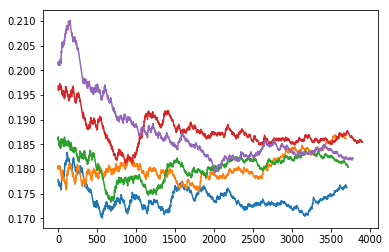

hit ratio: [0.17806544708397273, 0.1820011451682404, 0.18593684325250806]
miss rate: [3040.018452999366, 3079.6291559241877, 3119.239858849009]
point estimates: [0.17413752460184578, 0.18034294215028462, 0.18055837914632442, 0.18746865483277184, 0.18749822510997521]


In [128]:
res = run_simulation(10, 1000, fifo, 500, 5, 200)
for r in res:
    plt.plot(r)
plt.show()
print("hit ratio: {}".format(get_ci([np.mean(r) for r in res])))
print("miss rate: {}".format(get_ci([len(r) * (1 - np.mean(r)) for r in res])))
print("point estimates: {}".format([np.mean(r) for r in res]))

In [157]:
m = 2
n = 3
S_rand = []
ls = [1 / (i + 1) for i in range(n)]
sig = sum(ls)
ps = [1 / ((i + 1) * sig) for i in range(n)]
for i in range(1, n + 1):
    for j in range(i + 1, n + 1):
        S_rand.extend([(i, j), (j, i)])

p_out = (1 / m) * ((n - m) / n)
Q = [[0 for _ in S_rand] for _ in S_rand]
for i, s1 in enumerate(S_rand):
    for j, s2 in enumerate(S_rand):
        if s1[0] == s2[0] and s1[1] != s2[1]:
            Q[i][j] = 1 / m * ps[s2[1] - 1]
        elif s1[0] != s2[0] and s1[1] == s2[1]:
            Q[i][j] = 1 / m * ps[s2[0] - 1]
for i, r in enumerate(Q):
    Q[i][i] = -sum(r)
print("Generator matrix: ")
print(np.array(Q))
for i in Q:
    i[-1] = 1
print("Augmented generator matrix: ")
print(np.array(Q))

[0.5454545454545455, 0.27272727272727276, 0.18181818181818182]
Generator matrix: 
[[-0.18181818  0.          0.09090909  0.          0.          0.09090909]
 [ 0.         -0.18181818  0.          0.09090909  0.09090909  0.        ]
 [ 0.13636364  0.         -0.27272727  0.          0.13636364  0.        ]
 [ 0.          0.13636364  0.         -0.27272727  0.          0.13636364]
 [ 0.          0.27272727  0.27272727  0.         -0.54545455  0.        ]
 [ 0.27272727  0.          0.          0.27272727  0.         -0.54545455]]
Augmented generator matrix: 
[[-0.18181818  0.          0.09090909  0.          0.          1.        ]
 [ 0.         -0.18181818  0.          0.09090909  0.09090909  1.        ]
 [ 0.13636364  0.         -0.27272727  0.          0.13636364  1.        ]
 [ 0.          0.13636364  0.         -0.27272727  0.          1.        ]
 [ 0.          0.27272727  0.27272727  0.         -0.54545455  1.        ]
 [ 0.27272727  0.          0.          0.27272727  0.          

[(1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]


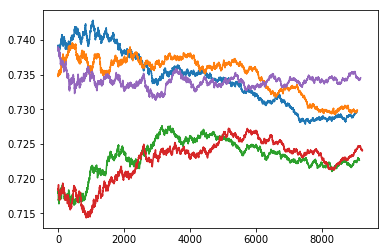

expected hit ratio: 0.7272727272727273
hit rate: [0.7241133999112894, 0.726381298116248, 0.7286491963212065]
miss rate: [2493.067197124741, 2513.3667632144225, 2533.666329304104]
point estimates: [0.7241189198462922, 0.7221882732888424, 0.7302431387035077, 0.7284264649906947, 0.7269296937519031]


In [153]:
p_rand = [1 / 4, 1 / 4, 1 / 6, 1 / 6, 1 / 12, 1 / 12] #Solution to global equilibrium equations
hit_ratio_rand = 0
print(S_rand)
for i, s in enumerate(S_rand):
    hit_ratio_rand += (ps[s[0] - 1] + ps[s[1] - 1]) * p_rand[i]
res = run_simulation(2, 3, rand, 5000, 5, 2000)
for r in sim:
    plt.plot(r)
plt.show()
print("expected hit ratio: {}".format(hit_ratio_rand))
print("hit rate: {}".format(get_ci([np.mean(r) for r in res])))
print("miss rate: {}".format(get_ci([len(r) * (1 - np.mean(r)) for r in res])))
print("point estimates: {}".format([np.mean(r) for r in res]))

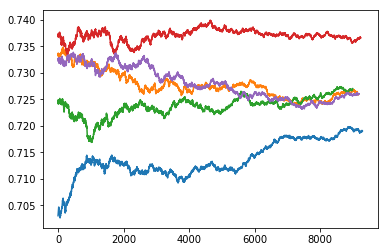

expected hit ratio: 0.7272727272727273
hit ratio: [0.7201112778651989, 0.726024441240697, 0.7319376046161951]
miss rate: [2452.523679056081, 2513.0783978468817, 2573.633116637682]
point estimates: [0.713660763224719, 0.7276929854319414, 0.7236950140891494, 0.7370252099784973, 0.7280482334791775]


In [154]:
p_fifo = [1 / 2, 1 / 6, 1 / 3] # manually calculated
hit_ratio_fifo = 0
S = [(1, 2), (2, 3), (3, 1)]
for i, s in enumerate(S):
    hit_ratio_fifo += (ps[s[0] - 1] + ps[s[1] - 1]) * p_fifo[i]
res = run_simulation(2, 3, fifo, 5000, 5, 2000)
for r in res:
    plt.plot(r)
plt.show()
print("expected hit ratio: {}".format(hit_ratio_fifo))
print("hit ratio: {}".format(get_ci([np.mean(r) for r in res])))
print("miss rate: {}".format(get_ci([len(r) * (1 - np.mean(r)) for r in res])))
print("point estimates: {}".format([np.mean(r) for r in res]))